# Homework 2 - Convolutional Neural Nets

In this homework, we will be working with google [colab](https://colab.research.google.com/). Google colab allows you to run a jupyter notebook on google servers using a GPU or TPU. To enable GPU support, make sure to press Runtime -> Change Runtime Type -> GPU.


## Cats vs dogs classification

To learn about and experiment with convolutional neural nets we will be working on a problem of great importance in computer vision - classifying images of cats and dogs.

The problem is so important that there's even an easter egg in colab: go to Tools -> Settings -> Miscellaneous and enable 'Corgi mode' and 'Kitty mode' to get more cats and dogs to classify when you're tired of coding.


### Getting the data

To get started with the classification, we first need to download and unpack the dataset (note that in jupyter notebooks commands starting with `!` are executed in bash, not in python):


In [1]:
! wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O ./cats_and_dogs_filtered.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
! unzip cats_and_dogs_filtered.zip

unzip:  cannot find either cats_and_dogs_filtered.zip or cats_and_dogs_filtered.zip.zip.


This dataset contains two directories, `train` and `validation`. Both in turn contain two directories with images: `cats` and `dogs`. In `train` we have 1000 images of cats, and another 1000 images of dogs. For `validation`, we have 500 images of each class. Our goal is to implement and train a convolutional neural net to classify these images, i.e. given an image from this dataset, tell if it contains a cat or a dog.


In [5]:
! echo 'Training cats examples:' $(find cats_and_dogs_filtered/train/cats -type f | wc -l)
! echo 'Training dogs examples:' $(find cats_and_dogs_filtered/train/dogs -type f | wc -l)
! echo 'Validation cats examples:' $(find cats_and_dogs_filtered/validation/cats -type f | wc -l)
! echo 'Validation dogs examples:' $(find cats_and_dogs_filtered/validation/dogs -type f | wc -l)

'wc' is not recognized as an internal or external command,
operable program or batch file.
'wc' is not recognized as an internal or external command,
operable program or batch file.
'wc' is not recognized as an internal or external command,
operable program or batch file.
'wc' is not recognized as an internal or external command,
operable program or batch file.


### Loading the data

Now that we have the data on our disk, we need to load it so that we can use it to train our model. In Pytorch ecosystem, we use `Dataset` class, documentation for which can be found [here](https://pytorch.org/docs/stable/data.html).

In the case of computer vision, the datasets with the folder structure 'label_name/image_file' are very common, and to process those there's already a class `torchvision.datasets.ImageFolder` (documented [here](https://pytorch.org/vision/0.8/datasets.html)). Torchvision is a Pytorch library with many commonly used tools in computer vision.

Another thing we need from Torchvision library is transforms ([documentation](https://pytorch.org/docs/stable/torchvision/transforms.html)). In computer vision, we very often want to transform the images in certain ways. The most common is normalization. Others include flipping, changing saturation, hue, contrast, rotation, and blurring.

Below, we create a training, validation and test sets. We use a few transforms for augmentation on the training set, but we don't use anything but resize and normalization for validation and test.


In [6]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image  # PIL is a library to process images

# These numbers are mean and std values for channels of natural images.
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Needed for plotting
unnormalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225],
)

train_transforms = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(hue=0.1, saturation=0.1, contrast=0.1),
        transforms.RandomRotation(20, interpolation=Image.BILINEAR),
        transforms.GaussianBlur(7, sigma=(0.1, 1.0)),
        transforms.ToTensor(),  # convert PIL to Pytorch Tensor
        normalize,
    ]
)

validation_transforms = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        normalize,
    ]
)

train_dataset = torchvision.datasets.ImageFolder(
    "./cats_and_dogs_filtered/train", transform=train_transforms
)
validation_dataset, test_dataset = torch.utils.data.random_split(
    torchvision.datasets.ImageFolder(
        "./cats_and_dogs_filtered/validation", transform=validation_transforms
    ),
    [500, 500],
    generator=torch.Generator().manual_seed(42),
)

Let's see what one of the images in the dataset looks like (you can run this cell multiple times to see the effects of different augmentations):


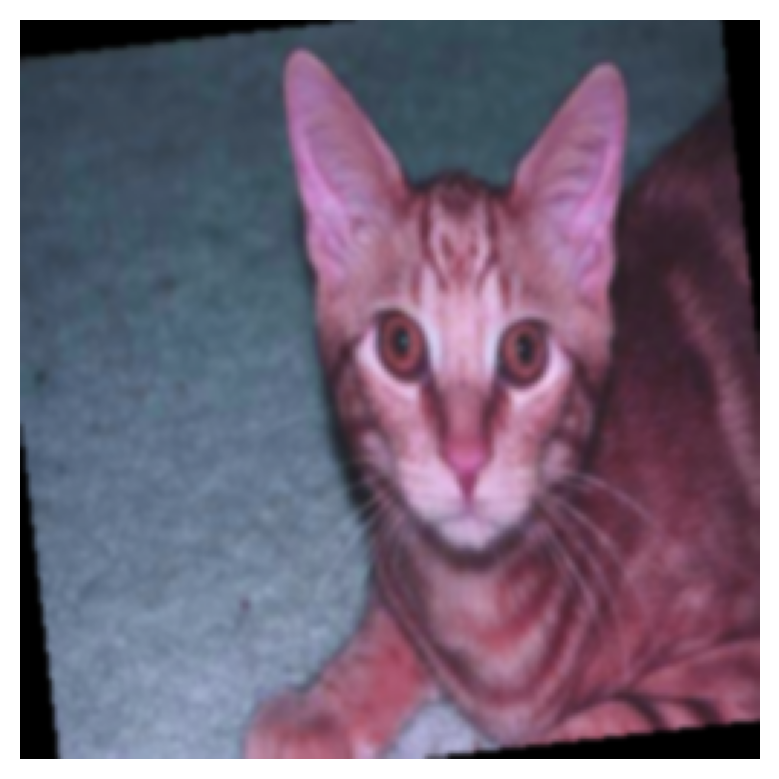

In [7]:
from matplotlib import pyplot as plt

plt.rcParams["figure.dpi"] = 200  # change dpi to make plots bigger


def show_normalized_image(img, title=None):
    plt.imshow(unnormalize(img).detach().cpu().permute(1, 2, 0))
    plt.title(title)
    plt.axis("off")


show_normalized_image(train_dataset[10][0])

### Creating the model


Now is the time to create a model. All models in Pytorch are subclassing `torch.nn.Module`, and have to implement `__init__` and `forward` methods.

Below we provide a simple model skeleton, which you need to expand. The places to put your code are marked with `TODO`. Here, we ask you to implement a convolutional neural network containing the following elements:

- Convolutional layers (at least two)
- Batch Norm
- Non-linearity
- Pooling layers
- A residual connection similar to that of Res-Net
- A fully connected layer

For some examples of how to implement Pytorch models, please refer to our lab notebooks, such as [this one](https://github.com/Atcold/pytorch-Deep-Learning/blob/master/06-convnet.ipynb).


In [8]:
torch.manual_seed(48)

In [10]:
from torch import nn
import torch.optim as optim
import torch.nn.functional as F

# NOTE: FIND THE FOLLOWING ONLINE/PAPER FOR RESNET
N = 4
a_1 = N**2
a_2 = N**3
SIZING = 64 * 14 * 14


class ResNetish(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size, padding="same"
        )
        self.conv2 = nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size, padding="same"
        )

    def forward(self, x):
        identity = x  # saving the residuals per architecture reqs
        out = F.relu(self.conv1(x))
        out = self.conv2(out)
        out += identity
        out = F.relu(out)
        return out



# the part we do

class CNN_Solution(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=a_1, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(a_1)
        self.res1 = ResNetish(in_channels=a_1, out_channels=a_1, kernel_size=3)
        self.conv2 = nn.Conv2d(a_1, a_2, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(a_2)
        self.res2 = ResNetish(in_channels=a_2, out_channels=a_2, kernel_size=3)
        self.conv3 = nn.Conv2d(a_2, a_2, kernel_size=3)

        self.fc1 = nn.Linear(SIZING, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 64)
        self.bn_fc2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 2)
        self.bn_fc3 = nn.BatchNorm1d(2)

    def forward(self, x):

        # Conv Layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.max_pool2d(x, kernel_size=4)
        x = F.relu(x)
        x = F.relu(self.res1(x))
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(x)
        x = F.relu(self.res2(x))
        x = self.conv3(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(x)

        # FC layers
        x = x.view(-1, SIZING)
        x = F.relu(self.fc1(x))
        x = self.bn_fc1(x)
        x = F.relu(self.fc2(x))
        x = self.bn_fc2(x)
        x = self.fc3(x)

        return F.softmax(x, dim=1)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_Solution()
print("Model Architecture:")
print(model)
print("device:", device)

Model Architecture:
CNN_Solution(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (res1): ResNetish(
    (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (conv2): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (res2): ResNetish(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=12544, out_features=512, bias=True)
  (bn_fc1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (bn_fc2): BatchNorm1d(64, ep

### Training the model

Now we train the model on the dataset. Again, we're providing you with the skeleton with some parts marked as `TODO` to be filled by you.


In [17]:
from tqdm.notebook import tqdm


def get_loss_and_correct(model, batch, criterion, device):
    # Implement forward pass and loss calculation for one batch.
    # Remember to move the batch to device.
    #
    # Return a tuple:
    # - loss for the batch (Tensor)
    # - number of correctly classified examples in the batch (Tensor)
    data, target = batch[0].to(device), batch[1].to(device)
    output = model(data)

    prediction = output.data.max(1, keepdim=True)[1]
    correct_count = prediction.eq(target.data.view_as(prediction)).cpu().sum()

    loss = criterion(output, target)

    return (loss, correct_count)


def step(loss, optimizer):
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


N_EPOCHS = 12
BATCH_SIZE = 64

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)
validation_dataloader = torch.utils.data.DataLoader(
    validation_dataset, batch_size=BATCH_SIZE, num_workers=2
)
model = CNN_Solution()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2.75e-4)

model.train()

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

pbar = tqdm(range(N_EPOCHS))

for i in pbar:
    total_train_loss = 0.0
    total_train_correct = 0.0
    total_validation_loss = 0.0
    total_validation_correct = 0.0

    model.train()

    for batch in tqdm(train_dataloader, leave=False):
        loss, correct = get_loss_and_correct(model, batch, criterion, device)
        step(loss, optimizer)
        total_train_loss += loss.item()
        total_train_correct += correct.item()

    with torch.no_grad():
        for batch in validation_dataloader:
            loss, correct = get_loss_and_correct(model, batch, criterion, device)
            total_validation_loss += loss.item()
            total_validation_correct += correct.item()

    mean_train_loss = total_train_loss / len(train_dataset)
    train_accuracy = total_train_correct / len(train_dataset)

    mean_validation_loss = total_validation_loss / len(validation_dataset)
    validation_accuracy = total_validation_correct / len(validation_dataset)

    train_losses.append(mean_train_loss)
    validation_losses.append(mean_validation_loss)

    train_accuracies.append(train_accuracy)
    validation_accuracies.append(validation_accuracy)

    pbar.set_postfix(
        {
            "train_loss": mean_train_loss,
            "validation_loss": mean_validation_loss,
            "train_accuracy": train_accuracy,
            "validation_accuracy": validation_accuracy,
        }
    )

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Now that the model is trained, we want to visualize the training and validation losses and accuracies:


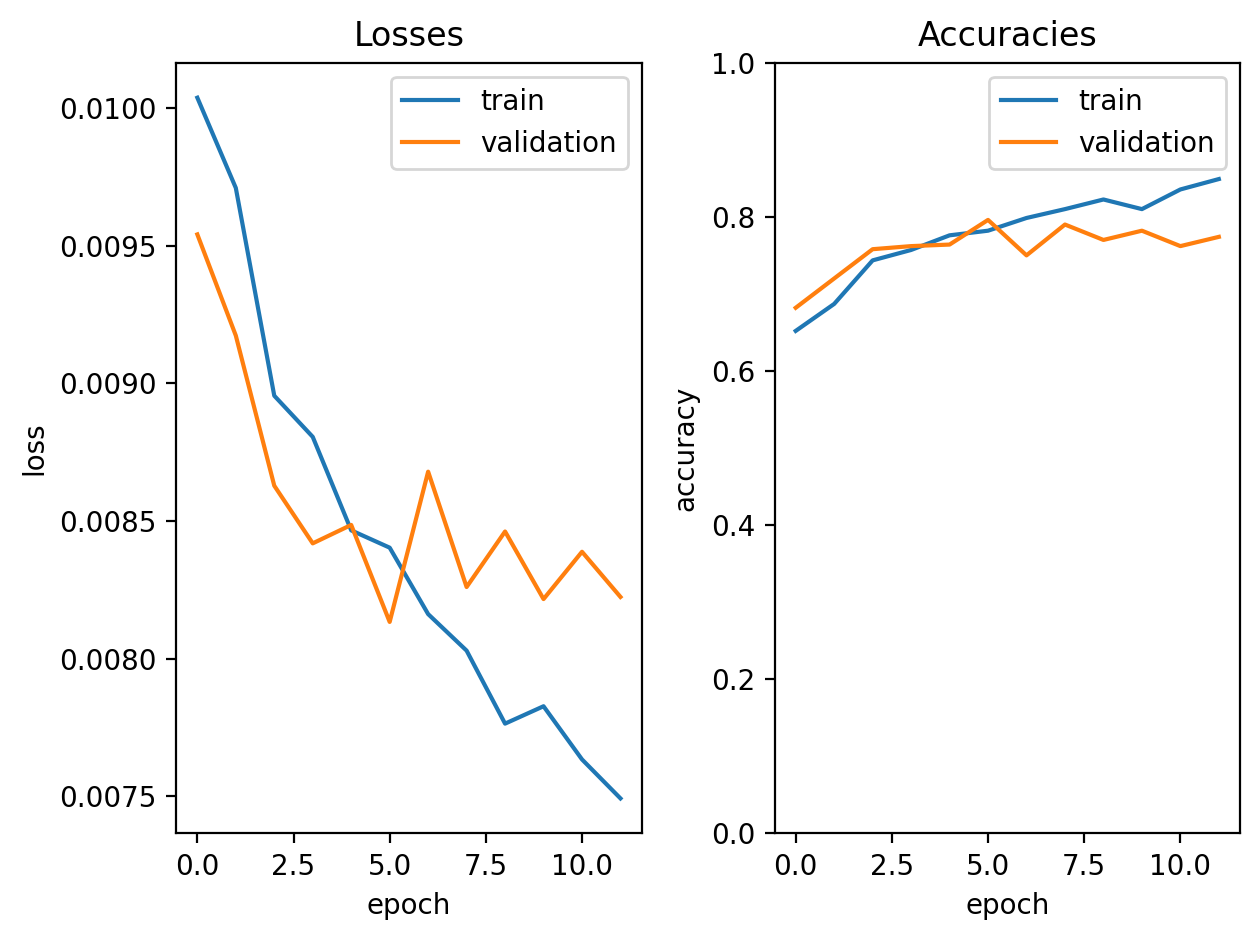

In [18]:
plt.figure(dpi=200)

plt.subplot(121)
plt.plot(train_losses, label="train")
plt.plot(validation_losses, label="validation")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Losses")
plt.legend()

plt.subplot(122)
plt.plot(train_accuracies, label="train")
plt.plot(validation_accuracies, label="validation")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.ylim(0, 1)
plt.title("Accuracies")

plt.tight_layout()

In [20]:
print(f"Final validation accuracy: {validation_accuracies[-1] * 100}%")

Final validation accuracy: 77.4%


Now, change your model to achieve at least 75% accuracy on validation set. You can change the model you've implemented, the optimizer, and the augmentations.

Looking at the loss and accuracy plots, can you see if your model overfits the trainig set? Why?

Answer:
No, the model is **not** overfitting the training set. The model is performing roughly equally on the training and validation set. The training accuracy has continued to improve, and we haven't seen the divergence of train/val accuracy that is characteristic of overfitting.


### Testing the model

Now, use the `test_dataset` to get the final accuracy of your model. Visualize some correctly and incorrectly classified examples.


In [19]:
# TODO
# 1. Calculate and show the test_dataset accuracy of your model.
# 2. Visualize some correctly and incorrectly classified examples.
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, num_workers=4
)

total_test_correct = 0.0
total_test_loss = 0.0
da_real_onez = []

model.eval()

criterion = nn.CrossEntropyLoss()

for batch in test_dataloader:
    data, target = batch[0].to(device), batch[1].to(device)

    output = model(data)
    predict = output.data.max(1, keepdim=True)[1]

    loss = criterion(output, target)

    da_real_onez = predict.eq(target.data.view_as(predict)).flatten()
    correct_count = correct.sum()

    total_test_correct += correct_count.item()
    total_test_loss += loss.item()

accuracy = total_test_correct / len(test_dataset)
print(f"Final test Accuracy: {accuracy}")

Final test Accuracy: 0.688


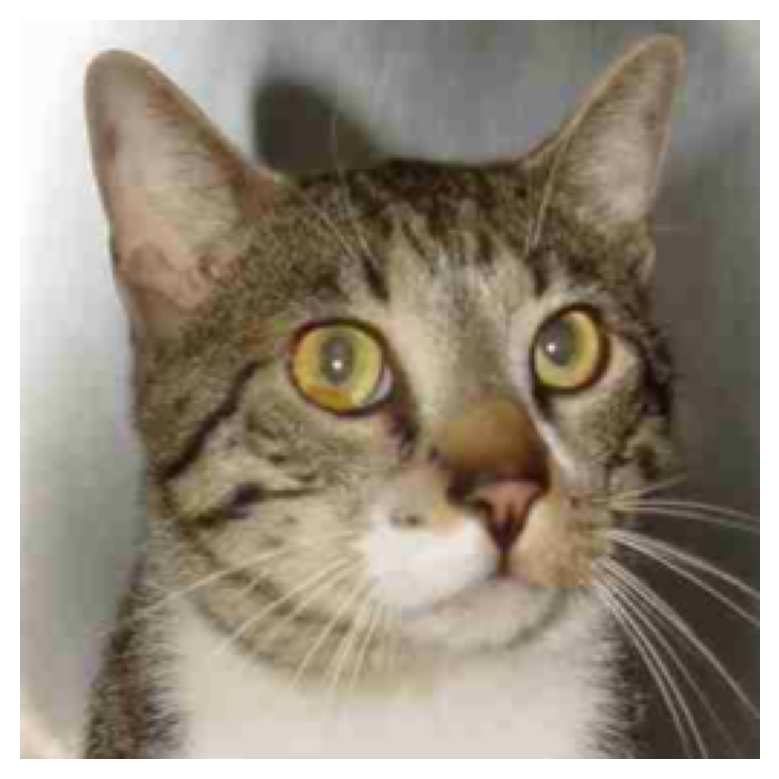

In [23]:
correct_images = data[da_real_onez]
incorrect_images = data[da_real_onez == False]
show_normalized_image(correct_images[5])

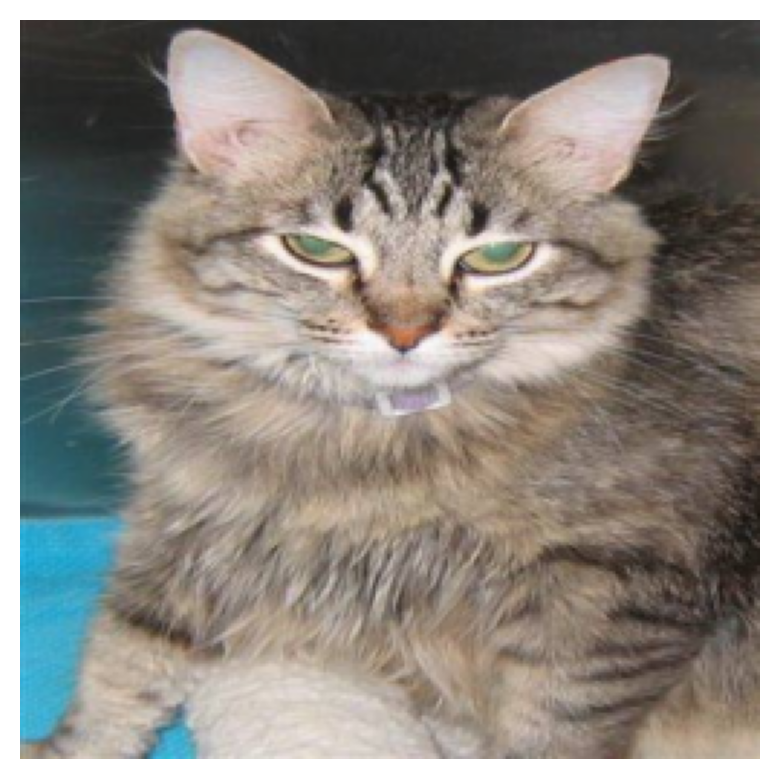

In [22]:
show_normalized_image(correct_images[15])

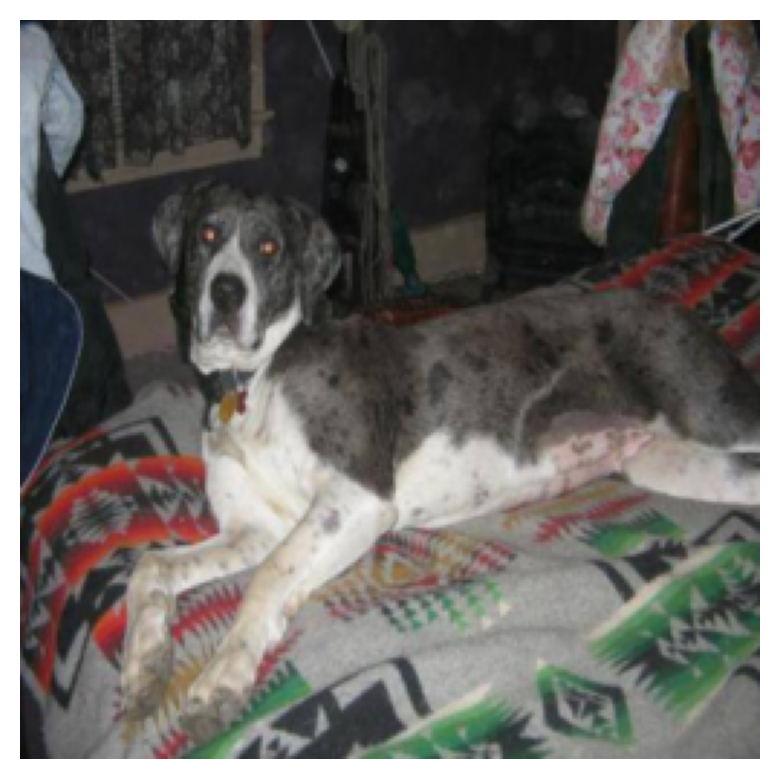

In [24]:
show_normalized_image(incorrect_images[2])

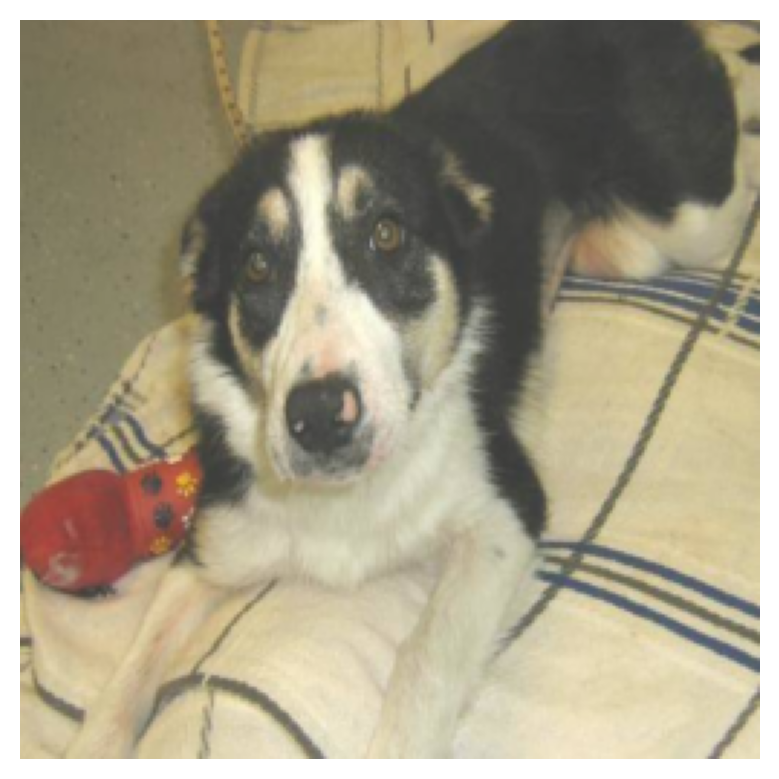

In [26]:
show_normalized_image(incorrect_images[1])

### Visualizing filters

In this part, we are going to visualize the output of one of the convolutional layers to see what features they focus on.

First, let's get some image.


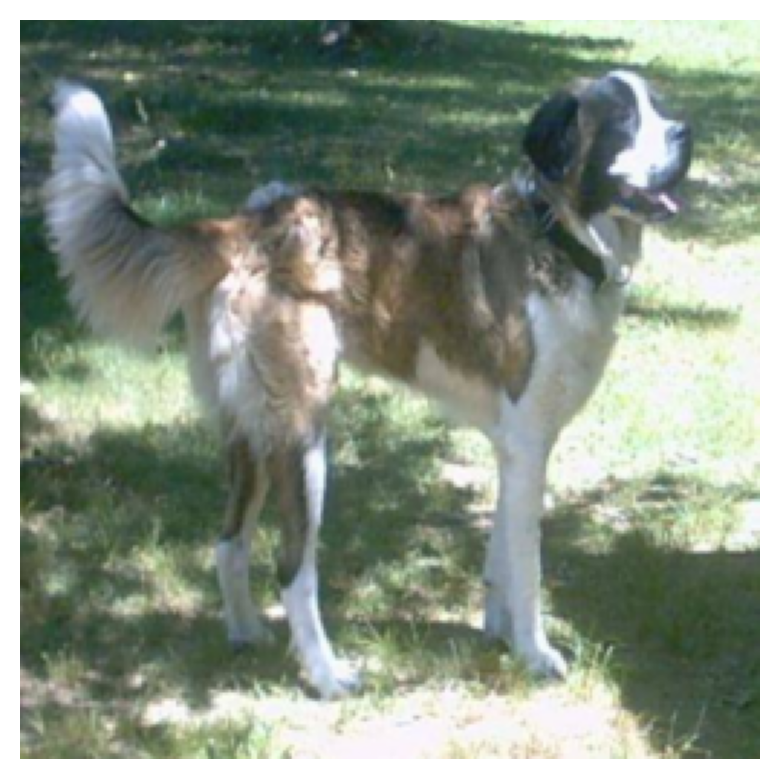

In [27]:
image = validation_dataset[10][0]
show_normalized_image(image)

Now, we are going to 'clip' our model at different points to get different intermediate representation.
Clip your model at two or three different points and plot the filters output.

In order to clip the model, you can use `model.children()` method. For example, to get output only after the first 4 layers, you can do:

```
clipped = nn.Sequential(
    *list(model.children()[:4])
)
intermediate_output = clipped(input)
```


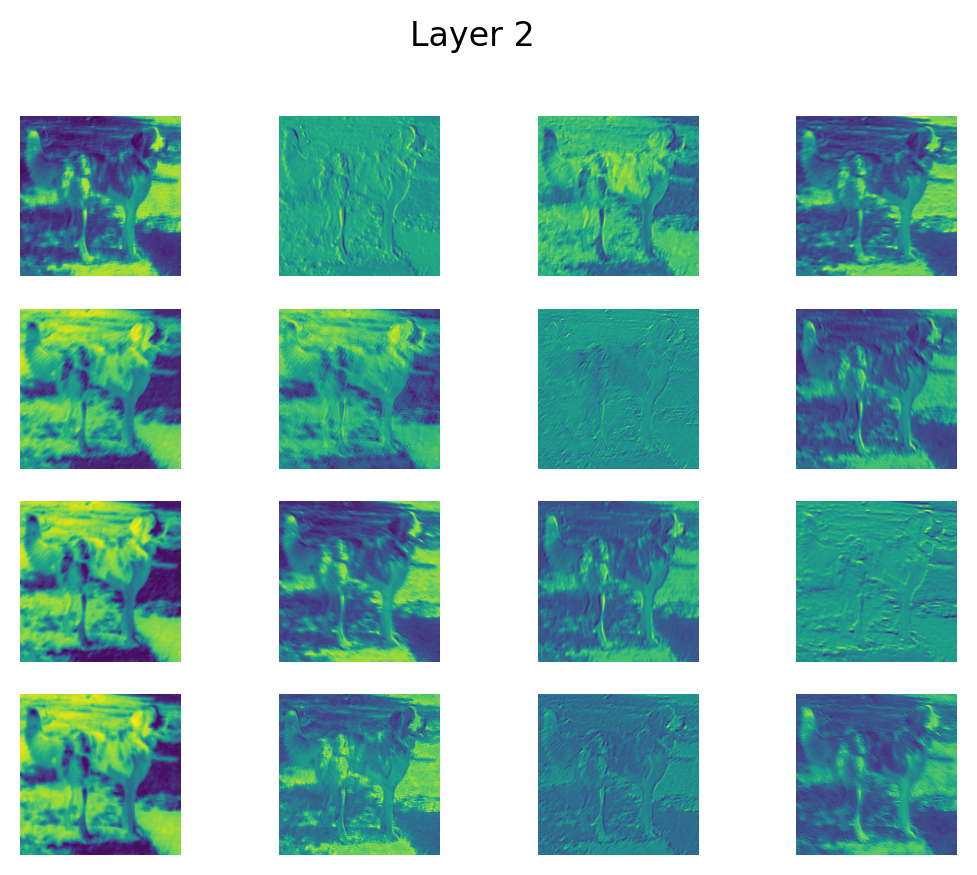

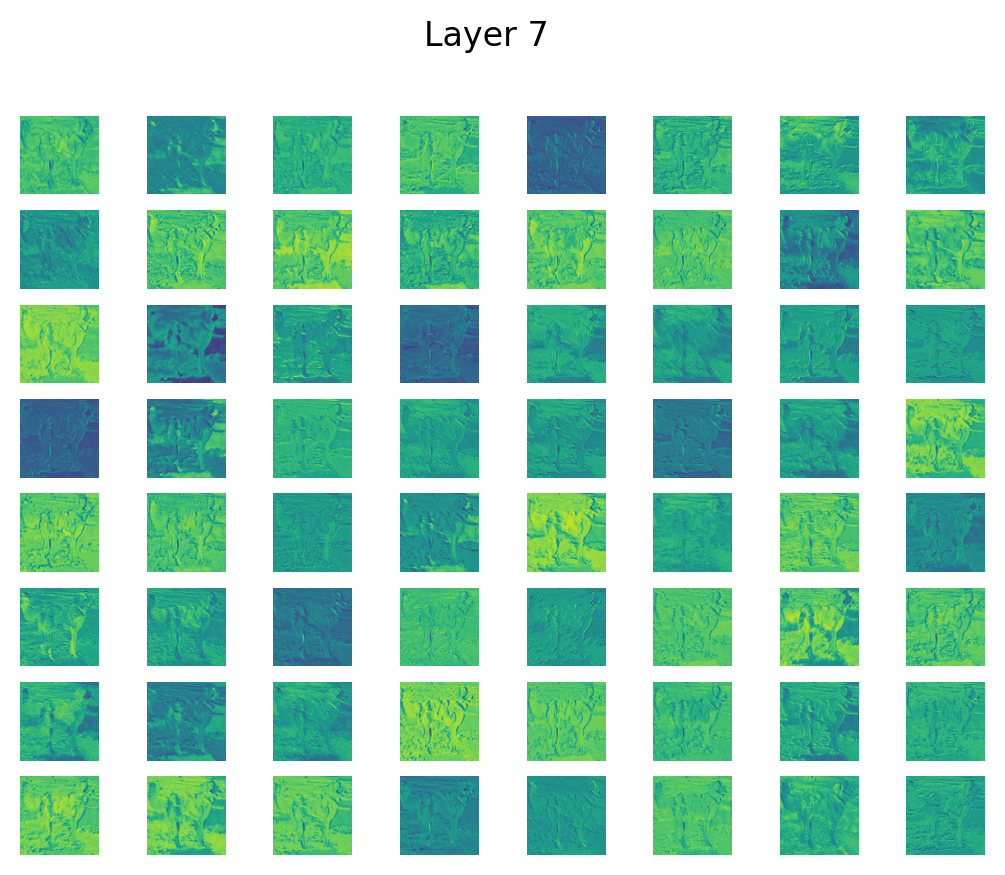

In [28]:
import math


def plot_intermediate_output(result, title):
    """Plots the intermediate output of shape
    N_FILTERS x H x W
    """
    n_filters = result.shape[1]
    N = int(math.sqrt(n_filters))
    M = (n_filters + N - 1) // N
    assert N * M >= n_filters

    fig, axs = plt.subplots(N, M)
    fig.suptitle(title)

    for i in range(N):
        for j in range(M):
            if i * N + j < n_filters:
                axs[i][j].imshow(result[0, i * N + j].cpu().detach())
                axs[i][j].axis("off")


# TODO
# pick a few intermediate representations from your network and plot them using
# the provided function.
clipped3 = nn.Sequential(*list(model.children())[:2])

intermediate_output = clipped3(torch.unsqueeze(image, 0).cuda())
plot_intermediate_output(intermediate_output, title="Layer 2")


clipped3 = nn.Sequential(*list(model.children())[:7])

intermediate_output = clipped3(torch.unsqueeze(image, 0).cuda())
plot_intermediate_output(intermediate_output, title="Layer 7")

What can you say about those filters? What features are they focusing on?

Anwer: Layer 2 seems to be more concerned with distinguising the salient features defining the dog, such as its head or tail. Layer 7, produced after a few convolutions, is more concerned with the general opacity of the image, focusing on differentiating dog from landscape.
